In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data
from dask.distributed import Client
from dask.distributed import as_completed
import openpyxl
import xlsxwriter
import pandas_datareader.data as web
import statsmodels.tsa.stattools as ts
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import pandas_market_calendars as mcal
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
end_ = datetime.today()
#start = end - relativedelta(years=2) - relativedelta(days=3)
start_ = end_ - relativedelta(months=64)
start_X2_ = end_ - relativedelta(months=64*2)

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start_, end_date=end_)

nyse_X2 = mcal.get_calendar('NYSE')
nyse_dates_X2 = nyse.schedule(start_date=start_X2_, end_date=end_)

start = nyse_dates.index[0]
start_X2 = nyse_dates_X2.index[0]

end = nyse_dates.index[-1]
print(start.strftime('%Y-%m-%d'))
print(end.strftime('%Y-%m-%d'))

2017-03-20
2022-07-18


In [3]:
"""
db_filename = '.\\data\\interim\\todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()
"""

"\ndb_filename = '.\\data\\interim\\todo.db'\n\ndb_is_new = not os.path.exists(db_filename)\n\nconn = sqlite3.connect(db_filename)\n\nif db_is_new:\n    print('Need to create schema')\nelse:\n    print('Database exists, assume schema does, too.')\n\nconn.close()\n"

In [4]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

invert_dict_indexes = {v: k for k, v in dict_indexes.items()}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [5]:
index_names = ['SP1500', 'SP500', 'SP600', 'SP400']
indexes = ['SPTM','SPY','SLY','MDYG']
sector_names = ['Communication Services ETF', 'Consumer Discretionary ETF', 'Consumer Staples ETF', 'Energy ETF', 'Financials ETF', 'Health Care ETF', 'Industrials ETF', 'Information Technology ETF', 'Materials ETF', 'Real Estate ETF', 'Utilities ETF']
sectors = ['VOX','VCR','VDC','VDE','VFH','VHT','VIS','VGT','VAW','VNQ','VPU']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

#M1_MONEY_MULTIPLIER = M1NS/BOGMBASE

FRED_Indicators = [
"ASPUS",\
"AWHAETP",\
"B432RG3A086NBEA",\
"BAA10Y",\
"BACDINA066MNFRBNY",\
"BACTSAMFRBDAL",\
"BAMLC0A0CM",\
"BAMLCC0A1AAATRIV",\
"BAMLCC0A4BBBTRIV",\
"BAMLH0A3HYC",\
"BAMLHYH0A0HYM2TRIV",\
"BOGMBASE",\
"BOGZ1FA105015103Q",\
"BOGZ1FA145050005Q",\
"BOGZ1FA205050005Q",\
"BOGZ1FA315050005Q",\
"BOGZ1FA385050005Q",\
"BOGZ1FL105015105Q",\
"BUSAPPWNSACA",\
"BUSLOANS",\
"CASTHPI",\
"CES0500000003",\
"CES4348400001",\
"CFNAI",\
"CFNAIDIFF",\
"CFSBCACTIVITYMFG",\
"CILACBQ158SBOG",\
"CIVPART",\
"COMREPUSQ159N",\
"CONSUMER",\
"CP",\
"CPALTT01USQ657N",\
"CPIAUCSL",\
"CSCICP03USM665S",\
"CSUSHPINSA",\
"CUSR0000SEHA",\
"CUUR0000SEHA",\
"DALLCIACBEP",\
"DCOILBRENTEU",\
"DCOILWTICO",\
"DEXCHUS",\
"DEXUSUK",\
"DFF",\
"DFII10",\
"DGORDER",\
"DGS1",\
"DGS10",\
"DGS1MO",\
"DGS2",\
"DGS30",\
"DGS3MO",\
"DGS5",\
"DRBLACBS",\
"DRCCLACBS",\
"DRSFRMACBS",\
"DTB3",\
"DTWEXBGS",\
"EMRATIO",\
"ERENTUSQ176N",\
"ETOTALUSQ176N",\
"FEDFUNDS",\
"FGCCSAQ027S",\
"FPCPITOTLZGUSA",\
"GASREGW",\
"GDPC1",\
"GFDEBTN",\
"GFDEGDQ188S",\
"GOLDAMGBD228NLBM",\
"GVZCLS",\
"HDTGPDUSQ163N",\
"HOSMEDUSM052N",\
"IC4WSA",\
"ICSA",\
"IIPUSNETIQ",\
"INDPRO",\
"INTDSRUSM193N",\
"IRLTLT01USM156N",\
"KCFSI",\
"LES1252881600Q",\
"LEU0252918500Q",\
"LFWA64TTUSM647S",\
"LRUN64TTUSQ156S",\
"LXXRCSA",\
"M1",\
"M1V",\
"M1NS",\
"M2V",\
"MABMM301USM189S",\
"MANMM101USA189S",\
"MEFAINUSA672N",\
"MEHOINUSA672N",\
"MEPAINUSA672N",\
"MICH",\
"MOGMBASE",\
"MORTGAGE30US",\
"MPRIME",\
"MSPUS",\
"MZMSL",\
"NEWORDER",\
"NFCI",\
"NROU",\
"NYSTHPI",\
"PAYEMS",\
"PCE",\
"PERMIT",\
"POP",\
"POPTOTUSA647NWDB",\
"PPIACO",\
"PRFI",\
"PSAVERT",\
"Q10096USQ144NNBR",\
"RECPROUSM156N",\
"RSAHORUSQ156S",\
"SPCS20RSA",\
"STLFSI2",\
"T10Y2Y",\
"T10Y3M",\
"T10YIE",\
"T5YIE",\
"T5YIFR",\
"TB3MS",\
"TCU",\
"TDSP",\
"TEDRATE",\
"TOTALSA",\
"TREAST",\
"TTLHH",\
"TWEXB",\
"UMCSENT",\
"U6RATE",\
"UNRATE",\
"USALOLITONOSTSAM",\
"USPHCI",\
"USREC",\
"USROA",\
"USROE",\
"USSLIND",\
"USSTHPI",\
"VIXCLS",\
"VXVCLS",\
"WDFUELLA",\
"WGS3MO",\
"WILLLRGCAPVAL",\
"WILLMICROCAPPR",\
"WPU0911",\
"WPUSI019011",\
"WPU101",\
"WTB3MS"    
]

currencies = ['EURUSD=X','GBPUSD=X','AUDUSD=X','BRLUSD=X','JPY=X']
future_commodities_nSP500 = list(['UUP','^IRX','^GSPC','ES=F','YM=F','NQ=F','RTY=F','ZB=F','ZN=F','ZF=F','ZT=F','GC=F','MGC=F','SI=F','SIL=F','PL=F','HG=F','PA=F','CL=F','HO=F','NG=F','RB=F','BZ=F','B0=F','ZC=F','ZO=F','KE=F','ZR=F','ZM=F','ZL=F','ZS=F','GF=F','HE=F','LE=F','CC=F','KC=F','CT=F','LBS=F','OJ=F','SB=F'])

etf_bonds = [*etf_bonds,*etf_muni_bonds,*etf_treasuries]

In [6]:
SP500ticker_list = pd.read_html('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
SP600ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]
SP400ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]


In [7]:
sp500 = SP500ticker_list['Symbol']
sp500 = [w.replace('.', '-') for w in sp500]
sp600 = SP600ticker_list['Ticker symbol']
sp600 = [w.replace('.', '-') for w in sp600]
sp400 = SP400ticker_list['Ticker symbol']
sp400 = [w.replace('.', '-') for w in sp400]


In [8]:
len(sp500)+len(sp600)+len(sp400)

1505

In [9]:
print(len(sp500))
SP1500 = list()
SP1500.extend(sp500)
sp600 = list(set(sp600).difference(SP1500))
print(len(sp600))
SP1500.extend(sp600)
sp400 = list(set(sp400).difference(SP1500))
print(len(sp400))
SP1500.extend(set(sp400).difference(SP1500))

503
601
401


In [10]:
#>.5The time series is mean reverting
#=.5 time series is a Geometric Brownian Motion
#<.5 time series is trending

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [11]:
sp1500_index_df = pd.DataFrame()

lists = ["sp500","sp600","sp400"]

for l in lists:
    if(l=='sp500'):
        df = pd.DataFrame(sp500,columns=['Symbol'])
        print(len(df))
        #range_ = 
        #print(range_)
        df['Market Index'] = pd.Series(["SP500" for x in range(0,len(df.index),1)])
    elif(l=='sp600'):
        df = pd.DataFrame(np.array(sp600),columns=['Symbol'])        
        print(len(df))        
        df['Market Index'] = pd.Series(["SP600" for x in range(len(df.index))])
        df.index = range(len(sp500),(len(sp500)+len(df.index)),1)        
    else:
        df = pd.DataFrame(np.array(sp400),columns=['Symbol'])
        print(len(df))
        df['Market Index'] = pd.Series(["SP400" for x in range(len(df.index))])
        df.index = range((len(sp500)+len(sp600)),(len(sp500)+len(sp600)+len(df.index)),1)
    sp1500_index_df = pd.concat([sp1500_index_df,df],axis=0)

503
601
401


In [12]:
len(sp1500_index_df)-len(SP1500)

0

In [13]:
def Fred_Data(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    
    temp = web.DataReader(str(name), 'fred', start_, end_)
    #temp = web.DataReader(npa[1][0],'fred',start,end)
    temp = temp.asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_.index)
    temp.columns = ['Value']
    #temp.index = pd.to_datetime(temp.index)
    
    #temp['Symbol'] = name
    
    #print(temp)
    #temp_new = temp.asfreq('D').interpolate(method='time')    
    temp_dates = pd.date_range(temp.index[0].strftime('%Y-%m-%d'), temp.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp.reindex(nyse_inbetween_temp_dates)
    temp_new['Symbol'] = name
    
    #temp = temp.resample(frequency).mean().dropna()
    return(temp_new)
    #return(temp)

In [14]:

def dl(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    subset = yf.download(name, start=start_, end=end_, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    
    temp_new = subset.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(subset.index[0].strftime('%Y-%m-%d'), subset.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    subset_ = temp_new
    subset_['Symbol'] = name

    return (subset_)
    
def dl2(assets):

    yahoo_financials = YahooFinancials(assets)

    data = yahoo_financials.get_historical_price_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), time_interval='daily')
    return(data)

In [15]:
def getStock(npa):
    symbol = npa[0]
    start_=npa[1]
    end_=npa[2]
    
    data_ = yf.download(symbol, start=start_,end=end_)
  
    return([symbol,data_])

In [16]:
def getTickerData(npa):
    symbol = npa[0]
    
    stock_data = yf.Ticker(symbol) 
    return([symbol,stock_data])

In [17]:
def getSector(npa):
    #position = npa[0]
    symbol = npa[0]
    #start_=npa[2]
    #end_=npa[3]
    
    tickerdata = yf.Ticker(symbol)
    
    if 'sector' in tickerdata.info:
        sector = tickerdata.info['sector']
    else:
        sector = 'error'

    if 'industry' in tickerdata.info:
        industry = tickerdata.info['industry']
    else:
        industry = 'error'

    return([symbol,sector,industry])

In [18]:
def derive_price_supply_trends(npa_):
    name = npa_[0]
    data = npa_[1]
    nyse_dates_ = npa_[2]
    
    temp_new = data.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(data.index[0].strftime('%Y-%m-%d'), data.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    
    data_ = temp_new
    data_['Symbol'] = name

    """
    if(np.sum(duplicates==names_prices[n])>0):
        #potential duplicate
        if((np.sum((np.unique(prices_df['Symbol']))==n))>0):
            pass
        else:
            prices_df = pd.concat([prices_df,data_],axis=0)            
    else:
    """
    
    data_['trailing_1yr_max'] = (pd.DataFrame(data_)['High']).rolling(252).max()
    data_['MIN_Lookback_One_Year'] = data_['trailing_1yr_max'].rolling(252).min()
    #data_['MIN_Lookback_6_Months'] = data_['trailing_1yr_max'].rolling(126).min()
    data_['MIN_Lookback_2_Months'] = data_['trailing_1yr_max'].rolling(42).min()
    data_['MIN_Lookback_1_Months'] = data_['trailing_1yr_max'].rolling(21).min()

    data_['trailing_1yr_min'] = (pd.DataFrame(data_)['Low']).rolling(252).min()
    
    data_['supply_trend_1yr'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(252).min()
    
    #data_['supply_trend_180d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(126).min()
    
    #data_['supply_trend_90d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(63).min()
    
    data_['supply_trend_60d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(42).min()
    
    data_['supply_trend_30d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(21).min()

    data_['trailing_60d_max'] = (pd.DataFrame(data_)['High']).rolling(42).max()
    data_['trailing_60d_min'] = (pd.DataFrame(data_)['Low']).rolling(42).min()
    
    data_['trailing_30d_max'] = (pd.DataFrame(data_)['High']).rolling(21).max()
    data_['trailing_30d_min'] = (pd.DataFrame(data_)['Low']).rolling(21).min()
    
    data_['90dSMA'] = (pd.DataFrame(data_)['Adj Close']).rolling(63).mean()
    
    data_['90dSDev'] = (pd.DataFrame(data_)['Adj Close']).rolling(63 ).std()
    
    data_['TP'] = (data_['Adj Close'] + data_['Low'] + data_['High'])/3
    data_['21dstdTP'] = data_['TP'].rolling(21).std(ddof=0)
    data_['21dMA-TP'] = data_['TP'].rolling(21).mean()
    data_['21dBOLU'] = data_['21dMA-TP'] + 2*data_['21dstdTP']
    data_['21dBOLD'] = data_['21dMA-TP'] - 2*data_['21dstdTP']    

    data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
    data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
    
    data_['risk_per_share'] = data_['trailing_risk_40d_max']-data_['trailing_risk_40d_min']
    
    data_['30d_vol'] = (pd.DataFrame(data_)['Volume']).rolling(21).sum()
    data_['30d_vol_2yr'] = data_['30d_vol'].rolling(512).mean()
    data_['volume_factor'] = data_['30d_vol']/data_['30d_vol_2yr']
    
    #data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_6_Months']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    
    data_['risk_trend_factor'] = data_['1YMF']/data_['risk_per_share']
    
    return(data_)

In [19]:
def calculateMetrics(data_):
    
    df_line = data_[['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']].iloc[[-1]].reset_index().set_index('Symbol')
    name = df_line.index[0]
    adf = ts.adfuller(data_['Adj Close'].values)[1]
    
    hurst_ = hurst(data_['Adj Close'].values)
    
    #temp_ = prices_df[prices_df['Symbol']=='GO']
    #temp__ = temp_[['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']].iloc[[-1]].reset_index().set_index('Symbol')

    try:
        adf = ts.adfuller(data_['Adj Close'].values)[1]
    except:
        adf = 'error'

    try:
        hurst_ = hurst(data_['Adj Close'].values)
    except:
        hurst_ = 'error'

    temp = pd.concat([df_line,pd.DataFrame([adf],index=[name],columns=['adf']),pd.DataFrame([hurst_],index=[name],columns=['hurst'])],axis=1)
    temp.columns = ['Date',*temp.columns[1:]]
    return(temp)
    
    """
    n_ = data_df['Symbol'].values[-1]
    
    latest_p = pd.DataFrame(data_df)['Adj Close'][-1]
    oneYearDate = pd.DataFrame(data_df)['Adj Close'][[-1]].index[0] - relativedelta(years=1)
    
    #separate subset for past year.
    past_year = data_df[data_df.index>=oneYearDate.strftime('%Y-%m-%d')]
    
    #np.max(npa[np.where(np.array(names_prices)=='GBX')[0][0]]['High'])
    #max_2y = pd.DataFrame(data_df)['High'].rolling(504).max()[-1]
    #min_2y = pd.DataFrame(data_df)['Low'].rolling(504).min()[-1]
    
    #quantiles_close_2y = data_df['Adj Close'].rolling(504).quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])[-1]
    #quantiles_close_2y = data_df['Adj Close'].quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])
    
    std_2y = pd.DataFrame(data_df)['Adj Close'].rolling(504).std()[-1]
    mean_2y = pd.DataFrame(data_df)['Adj Close'].rolling(504).mean()[-1]
    
    #max_1y = past_year['High'].rolling(252).max()[-1]
    #min_1y = past_year['Low'].rolling(252).min()[-1]
    
    #quantiles_close_1y = data_df['Adj Close'].rolling(252).quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])[-1]
    #quantiles_close_1y = past_year['Adj Close'].quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])
    
    std_1y = past_year['Adj Close'].rolling(252).std()[-1]
    mean_1y = past_year['Adj Close'].rolling(252).mean()[-1]
    
    risk_trend_factor = data_df['risk_trend_factor'][-1]
    
    supply_trend_1yr = data_df['supply_trend_1yr'][-1]
    #supply_trend_180d = data_df['supply_trend_180d'][-1]
    #supply_trend_90d = data_df['supply_trend_90d'][-1]
    supply_trend_60d = data_df['supply_trend_60d'][-1]
    supply_trend_30d = data_df['supply_trend_30d'][-1]
    
    MIN_Lookback_One_Year = data_df['MIN_Lookback_One_Year'][-1]
    #MIN_Lookback_6_Months = data_df['MIN_Lookback_6_Months'][-1]
    MIN_Lookback_2_Months = data_df['MIN_Lookback_2_Months'][-1]
    MIN_Lookback_1_Months = data_df['MIN_Lookback_1_Months'][-1]
    
    adf = ts.adfuller(data_df['Adj Close'].values)[1]
    
    hurst_ = hurst(data_df['Adj Close'].values)

    volume_factor = data_df['volume_factor'][-1]
    vol_30d = data_df['30d_vol'][-1]
    vol_30d_2yr = data_df['30d_vol_2yr'][-1]
    
    pct_2yr = (latest_p - min_2y)/(max_2y-min_2y)
    pct_1yr = (latest_p - min_1y)/(max_1y-min_1y)
    
    ymf = data_df['1YMF'][-1]
    
    return([n_,max_2y,min_2y,std_2y,mean_2y,max_1y,min_1y,std_1y,mean_1y,latest_p,*quantiles_close_2y,*quantiles_close_1y,risk_trend_factor,supply_trend_1yr,supply_trend_60d,supply_trend_30d,vol_30d_2yr,pct_1yr,pct_2yr,MIN_Lookback_One_Year, MIN_Lookback_2_Months, MIN_Lookback_1_Months,vol_30d,volume_factor,adf,hurst_,ymf])
    """

In [20]:
def extractTickerValues(npa):
    
    n_ = npa[0]
    r_ = npa[1]
    #print(r_)
    print(n_)

    subset = pd.DataFrame([r_.info])

    others = ['quarterly_balance_sheet','quarterly_cashflow','quarterly_dividends','quarterly_earnings','quarterly_financials','mutualfund_holders','options','sustainability']

    o_items = []

    #print(r_)
    for o in others:
        if(np.sum(np.array(dir(r_))==[o])>0):
            o_item = getattr(r_, o)
            o_items.append([o,o_item])            

    
    values = pd.DataFrame()

    trackers = ['beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']

    for t in trackers:
        if(np.sum(np.where(subset.columns==t))==0):
            values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
        else:
            values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)

    return([n_,values,o_items])

In [21]:

npa = []
for f in [*future_commodities_nSP500,*currencies]:
    npa.append([f,start_X2,end])
    

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_commodities_futures = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_commodities_futures.append("error")
    else:
        results_commodities_futures.append(f.result()) 
client.close()

"""
data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
"""

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ndata_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()\ndata_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()\n"

In [22]:
future_commodities_nSP500_df = pd.DataFrame()

for r_df in results_commodities_futures:
    temp_df = r_df[1].asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_X2.index)
    temp_dates = pd.date_range(temp_df.index[0].strftime('%Y-%m-%d'), temp_df.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_X2.index[(nyse_dates_X2.index >= temp_dates[0]) & (nyse_dates_X2.index <= temp_dates[-1])]
    temp_new = temp_df.reindex(nyse_inbetween_temp_dates)
    temp_new['Symbol'] = r_df[0]
    
    future_commodities_nSP500_df = pd.concat([future_commodities_nSP500_df,temp_new],axis=0)

In [23]:
future_commodities_nSP500_pvt = pd.pivot_table(future_commodities_nSP500_df, values=['Adj Close'], index=future_commodities_nSP500_df.index,columns=['Symbol'])

In [24]:
future_commodities_nSP500_pvt.columns = future_commodities_nSP500_pvt.columns.droplevel(0)

In [25]:
tbill_df = Fred_Data(['DGS3MO',start_X2,end,nyse_dates])[['Value']]
tbill_df.columns = ['DGS3MO']


In [39]:
future_commodities_nSP500_pvt_w_Fred = pd.concat([tbill_df,future_commodities_nSP500_pvt],axis=1)
future_commodities_nSP500_pvt_w_Fred.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_nSP500_pvt_w_Fred.csv')

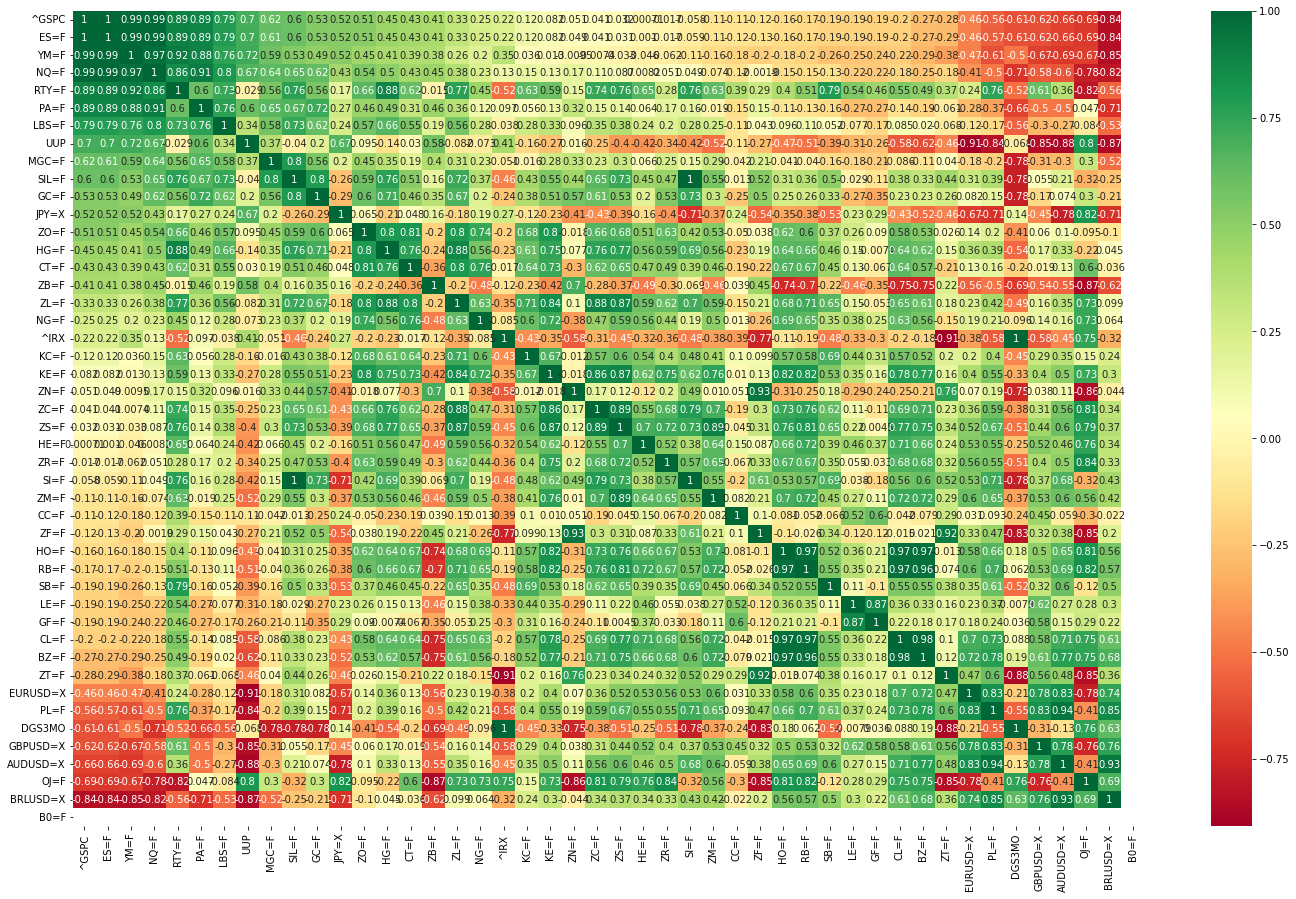

In [42]:
sorted_by_GSPC_future_commodities_corr = future_commodities_nSP500_pvt_w_Fred.corr().sort_values(by='^GSPC',ascending=False,axis=0).sort_values(by='^GSPC',ascending=False,axis=1)
sorted_by_GSPC_future_commodities_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_corr.csv')
import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_nSP500_pvt_w_Fred[sorted_by_GSPC_future_commodities_corr.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


In [28]:
trending = pd.DataFrame((future_commodities_nSP500_pvt_w_Fred['^GSPC']-future_commodities_nSP500_pvt_w_Fred['^GSPC'].shift(40))>0)
trending.columns = ['trending']

In [30]:
trending_df = pd.concat([future_commodities_nSP500_pvt_w_Fred,trending],axis=1)
future_commodities_trending = trending_df[trending_df['trending']==True]
future_commodities_not_trending = trending_df[trending_df['trending']!=True]

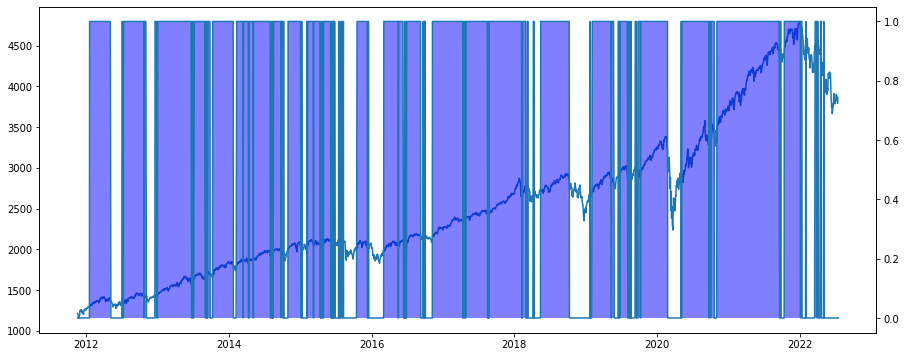

In [31]:
fig, ax1 = plt.subplots( figsize=(15,6) )

ax2 = ax1.twinx()

ax1.plot(trending_df[['^GSPC']])
ax2.plot(trending_df[['trending']])
ax2.fill_between(trending_df.index, 0, 1, where=trending_df['trending'] == True,facecolor='blue', alpha=0.5)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_SP500_trending.png', dpi=300, format='png', bbox_inches='tight')


correlations when trending
1920


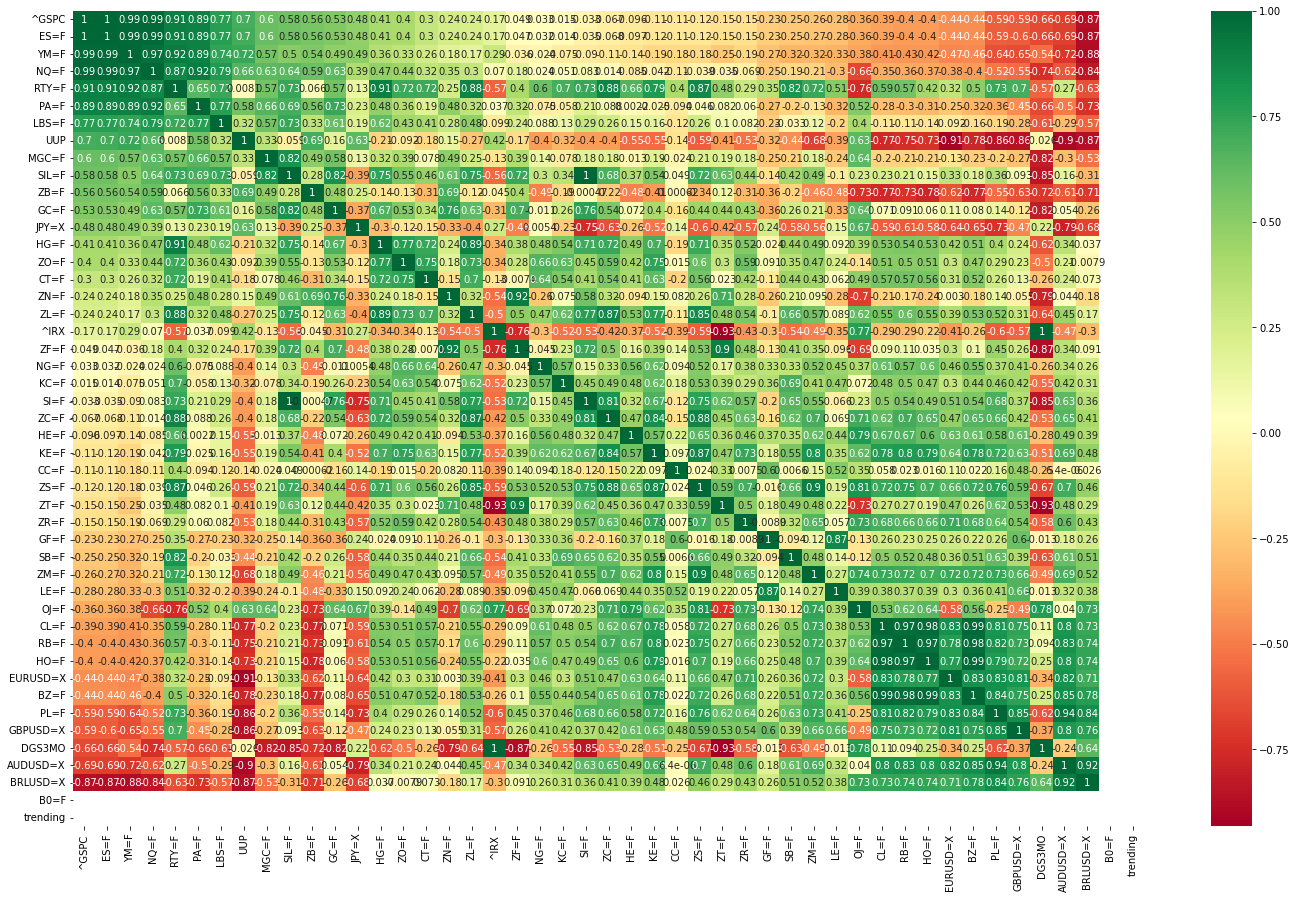

In [32]:
print("correlations when trending")
print(len(future_commodities_trending))

sorted_future_commodities_trending = future_commodities_trending.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_trending[sorted_future_commodities_trending.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

correlations when not trending
762


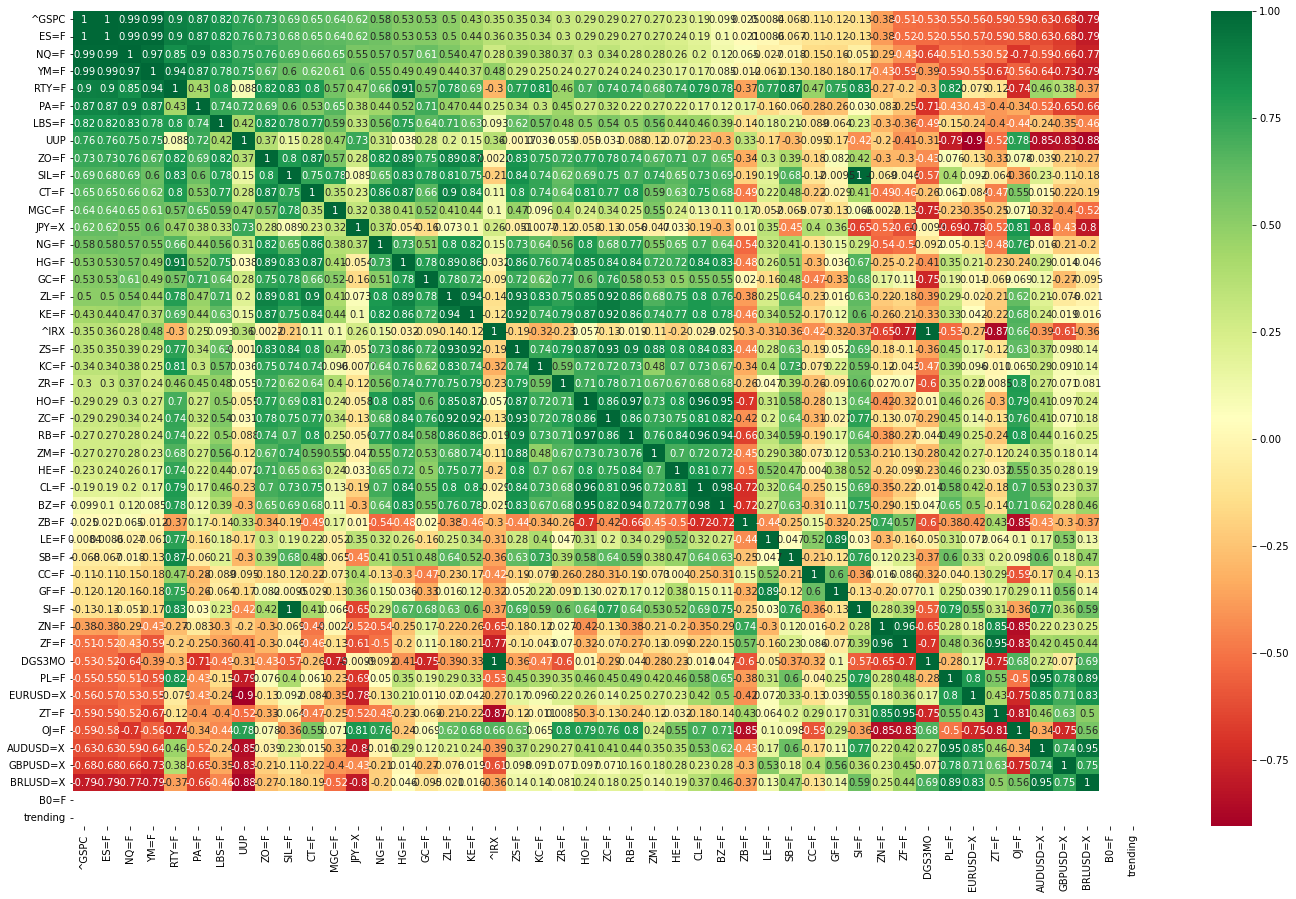

In [33]:
print("correlations when not trending")
print(len(future_commodities_not_trending))

sorted_future_commodities_not_trending = future_commodities_not_trending.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

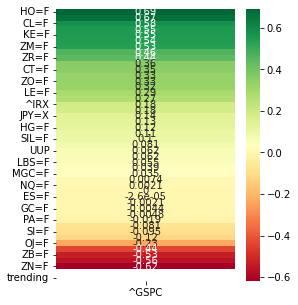

In [34]:
plt.figure(figsize=(4,5))
sns.heatmap((sorted_future_commodities_not_trending-sorted_future_commodities_trending).sort_values(by=['^GSPC'],ascending=False),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_trending-not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [35]:
import scipy

n = len(future_commodities_not_trending)

dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
p_not_trending = pd.DataFrame(2*dist.cdf(-abs(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr())),columns=future_commodities_not_trending.columns,index=sorted_future_commodities_not_trending.index)

n = len(future_commodities_trending)

dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
p_trending = pd.DataFrame(2*dist.cdf(-abs(future_commodities_trending[sorted_future_commodities_trending.index].corr())),columns=future_commodities_trending.columns,index=sorted_future_commodities_trending.index)
#p_trending = pd.DataFrame([2*dist.cdf(-abs(future_commodities_trending[sorted_future_commodities_trending.index].corr()))],columns=sorted_future_commodities_trending.columns,index=sorted_future_commodities_trending.index)


In [36]:
def highlight_cells(cell):
    #def inner(cell):
    color = 'green' if cell == True else ''
    return 'background-color: {}'.format(color)
    #return inner

In [37]:

temp_all_significant = pd.DataFrame((pd.DataFrame(p_not_trending)<.05)*(pd.DataFrame(p_trending)<.05)*(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr()*future_commodities_trending[sorted_future_commodities_trending.index].corr())>0)
temp_all_significant_inverted = pd.DataFrame((pd.DataFrame(p_not_trending)<.05)*(pd.DataFrame(p_trending)<.05)*(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr()*future_commodities_trending[sorted_future_commodities_trending.index].corr())<0)
temp_trend_significant = pd.DataFrame(pd.DataFrame(p_trending)<.05)
temp_not_trend_significant = pd.DataFrame(pd.DataFrame(p_not_trending)<.05)

combined = pd.concat([temp_trend_significant.loc[['^GSPC']].T,temp_not_trend_significant.loc[['^GSPC']].T,temp_all_significant.loc[['^GSPC']].T,temp_all_significant_inverted.loc[['^GSPC']].T],axis=1)
combined.columns = ['trend','not_trend','both','inverted']
display(combined.style.applymap(highlight_cells))



C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,trend,not_trend,both,inverted
DGS3MO,True,True,True,False
AUDUSD=X,True,True,True,False
B0=F,True,True,False,False
BRLUSD=X,True,True,True,False
BZ=F,True,True,False,True
CC=F,True,True,True,False
CL=F,True,True,False,True
CT=F,True,True,True,False
ES=F,True,True,True,False
EURUSD=X,True,True,True,False


In [ ]:
#test

import pandas as pd
import datetime as dt
dates = []
for d in pd.read_csv('..\\data\\raw\\sample.csv')['Date']:
    dates.append(dt.datetime.strptime(d, '%d-%b-%y'))

temp = pd.read_csv('..\\data\\raw\\sample.csv',thousands=",")
temp.index = dates
temp = temp.iloc[:,1:]
temp.columns = ['Open','High','Low','Adj Close','Volume']
#temp['Close'] = temp['Close'].astype(float)
temp.sort_index(inplace=True)
temp['Symbol'] = 'Test'

temp_new = derive_price_supply_trends(['temp',temp,nyse_dates]).sort_index(ascending=False)
print(temp_new)
print(calculateMetrics(temp_new))
#


In [ ]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i],start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d')])
    
# = getStock(npa[0])
    
client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_prices = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_prices.append("error")
    else:
        results_prices.append(f.result()) 
client.close()


In [ ]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i]])

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(getTickerData, npa)

results_ticker_data = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_data.append("error")
    else:
        results_ticker_data.append(f.result()) 
#client.restart()
client.close()


In [ ]:
print(results_ticker_data[0][1].info)
print(results_ticker_data[0][1].quarterly_balance_sheet)
print(results_ticker_data[0][1].quarterly_cashflow)
#print(results_ticker_data[0][1].quarterly_dividends)
print(results_ticker_data[0][1].quarterly_earnings)
print(results_ticker_data[0][1].quarterly_financials)


In [ ]:
results_ticker_data[0][1].info

In [ ]:
npa = []
results_ticker_names = [r[0] for r in results_ticker_data]
for n in range(0,len(results_ticker_names),1):
    npa.append([results_ticker_names[n],results_ticker_data[n][1]])

In [ ]:

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(extractTickerValues, npa)

results_ticker_values = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_values.append("error")
    else:
        results_ticker_values.append(f.result()) 
client.close()

"""
trackers = ['beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']

for t in trackers:
    if(np.sum(np.where(subset.columns==t))==0):
        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
    else:
        values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)
"""

In [ ]:
import pickle

ticker_values = pd.DataFrame()

pickle_dumps = []

for r in results_ticker_values:
    if(r=='error'):
        pass
        #pd.DataFrame(np.repeat('error', len(trackers), axis = None),index=)
    else:                
        #print(r[1])
        subset = pd.DataFrame(r[1])
        subset.index = [r[0]]
        #print(subset)
        ticker_values = pd.concat([ticker_values,subset],axis=0)
        pickle_dumps.append([r[0],r[2]])
        #ticker_values = pd.concat([ticker_values,pd.DataFrame(r[1],index=[r[0]])],axis=0)

pd.DataFrame(ticker_values)

pickle.dump(pickle_dumps, open('..\\data\\interim\\fundamental.pkl', 'wb'))

In [ ]:
"""
missing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))
print(missing_ticker_values)

for r in range(0,len(missing_ticker_values)):
    r_ = missing_ticker_values[r]
    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)
    temp.columns = ticker_values.columns
    #.set_index(0).iloc[[0]].columns))])
    ticker_values = pd.concat([ticker_values,temp],axis=0)
"""


In [ ]:
market_data = pd.concat([ticker_values])

In [ ]:
names_prices = [rp[0] for rp in results_prices]

#def process_df(data_):
npa = []    
for n in range(0,len(names_prices)):
    #print(names_prices[n])
    n_ = names_prices[n]
    npa.append([n_,results_prices[n][1],nyse_dates])
    
    
prices_df = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(derive_price_supply_trends, npa)
#results_sectors = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        #results_sectors.append("error")
        pass
    else:
        #results_sectors.append(f.result())
        prices_df = pd.concat([f.result(),prices_df],axis=0)
client.close()

In [ ]:

npa = []
for s in names_prices:
    #print(s)
    subset = prices_df.iloc[np.where(prices_df['Symbol']==s)]
    if(len(subset)==0):
        pass
    else:
        npa.append(subset)

screenerMetrics = []

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(calculateMetrics, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        screenerMetrics.append("error")
    else:
        screenerMetrics.append(f.result()) 
client.close()



In [ ]:
screener_metrics = pd.concat(screenerMetrics)

In [ ]:

missing_screener_metrics = list(set([*SP1500,*indexes,*sectors]).difference([n for n in screener_metrics.index]))
print(missing_screener_metrics)

for r in range(0,len(missing_screener_metrics)):
    r_ = missing_screener_metrics[r]
    test = pd.DataFrame([np.repeat('missing',len(screener_metrics.columns))],index=[r_],columns=screener_metrics.columns)
    screener_metrics = pd.concat([screener_metrics,test],axis=0)

#pd.DataFrame(screener_metrics)

In [ ]:
#fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in pickle_dumps]#[e[0] for e in fundamentals_quarterlies]


In [ ]:
#summary = pd.concat([prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor']].iloc[[-1]].reset_index().set_index('Symbol') for name_ in np.unique(prices_df['Symbol'].values)]).reset_index()

In [ ]:


sector_performance = []
for v in sectors:
    sector_performance.append([v,screener_metrics.loc[[v]]['risk_trend_factor'].values[0]])
temp_v = pd.concat([pd.DataFrame([dict_sectors_reverse[v] for v in sectors]),pd.DataFrame(sectors)],axis=1)
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

In [ ]:
index_performance = []
for v in indexes:
    index_performance.append([v,screener_metrics.loc[[v]]['risk_trend_factor'].values[0]])
temp_i = pd.DataFrame(index_performance,index=indexes)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

In [ ]:

threshold = 0
#stock_fundamentals = market_data
#screener = screener_metrics
#stock_indexes = sp1500_index_df


#spdr_indexes = indexes
#spdr_indexes.columns=['Symbol']
#vanguard_sectors = sectors
#vanguard_sectors.columns=['Symbol']
screener_metrics_w_sp1500index = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(sp1500_index_df,on='Symbol',how='left')

screener_metrics_w_sp1500index_good = screener_metrics_w_sp1500index[screener_metrics_w_sp1500index['risk_trend_factor']!='missing']

risk_trend_threshold = screener_metrics_w_sp1500index_good['risk_trend_factor'].quantile(q=[threshold]).values[0]
stock_sectors = market_data['sector']

temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
#temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']

temp_index_symbol_map = pd.concat([sp1500_index_df,pd.DataFrame([invert_dict_indexes[s] for s in sp1500_index_df['Market Index']])],axis=1)
temp_index_symbol_map.columns = ['Symbol','Market Index','Index Symbol']

index_sector_merged = temp_sm.merge(temp_index_symbol_map.iloc[:,[0,2]], on='Symbol', how='left')

"""
for spdr_ in range(0,len(indexes)):
    spdr__ = indexes[spdr_]
    #spdr__i = indexes[spdr_]
    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__
    """

In [ ]:
risk_screened = screener_metrics_w_sp1500index_good[(screener_metrics_w_sp1500index_good['risk_trend_factor']>risk_trend_threshold) & (screener_metrics_w_sp1500index_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
#temp_df = risk_screened[['Symbol','Adj Close','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
#temp_df.set_index('Symbol',inplace=True)
#pd.concat([temp_df,temp_sm],axis=0)

#screened_final_set = risk_screened

In [ ]:
threshold_value = screener_metrics_w_sp1500index_good.dropna()['risk_trend_factor'].quantile([threshold])

In [ ]:
risk_trend_factor_sector_dict = dict()
for s in sectors:
    risk_trend_factor_sector_dict[s] = screener_metrics.loc[[s]]['risk_trend_factor'].values[-1]
    
risk_trend_factor_sector_dict['error']='error'

In [ ]:
"""
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['Market Index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
"""
#symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)


In [ ]:
#symbols_w_index_sector

In [ ]:
index_sector_merged

In [ ]:
#pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],columns=['Sector Symbol'],index=index_sector_merged['Symbol']
sector_symbols = pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],index=index_sector_merged['Symbol'],columns=['Sector Symbol'])

symbols_w_sector_rtf = pd.DataFrame([risk_trend_factor_sector_dict[s] for s in sector_symbols['Sector Symbol']],columns=['sector_risk_trend_factor'],index=sector_symbols.index)

#screener_final = pd.concat([screener_metrics,symbols_w_index_sector.set_index),symbols_w_sector_rtf,index_sector_merged[['Market Index','Sector']]],axis=1)



In [ ]:
screener_final = pd.concat([screener_metrics,symbols_w_sector_rtf,index_sector_merged.set_index('Symbol')[['Sector']],sector_symbols,index_sector_merged.set_index('Symbol')[['Market Index','Index Symbol']]],axis=1)

a = screener_final[screener_final['risk_trend_factor'].apply(type) != np.str_].sort_values(by='risk_trend_factor',ascending=False)
b = screener_final[screener_final['risk_trend_factor'].apply(type) == np.str_]
screener_sorted = pd.concat([a,b],axis=0)

In [ ]:
#pd.concat([screener_metrics.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['Market Index','Sector']]],axis=1)

In [ ]:
list_sector_n_indexes = []
list_stocks = []
for i in index_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
#for i in screened_final_set['Symbol'].values:
for i in sp1500_index_df['Symbol'].values:
    list_stocks.append(i)
stocks_ = list_stocks
#stocks_ = np.unique(list_stocks, return_index=True)[1]
#list__ = [list_[symbol] for symbol in sorted(stocks_)]
#list__ = ['MCK','MPC','APA','LNTH','MUSA','CIVI','VAW','VGT','EQT','XOM','DVN','MRO','EOG','HES','CEIX','SM','RRC','MUR','MTDR','PXD','OXY','PDCE','NFG','FANG','TWI','PBF','MANT','HRB','VDC','ACC','GO','TVTY','FCN','VIVO']

In [ ]:
#screener_sorted.head(50)

In [ ]:
"""
rick_screener_final = rick_screener.dropna()[rick_screener.dropna()['risk_trend_factor'].values > threshold_value.values[0]]
rick_screener_final = pd.concat([rick_screener,rick_screener_final],axis=0).drop_duplicates(keep='last')

diff_ = np.setdiff1d(np.array([*list_sector_n_indexes,*stocks_]),rick_screener_final.index)

for d in diff_:
    rick_screener_final = pd.concat([rick_screener_final,pd.DataFrame([np.repeat(np.nan, len(rick_screener_final.columns))],columns=rick_screener_final.columns,index=[d])],axis=0)
    
rick_screener_final.loc[np.setdiff1d([*rick_screener_final.index],list_sector_n_indexes)].sort_values(by='risk_trend_factor',ascending=False).to_csv('rick_screener_final.csv')
"""
#screener_sorted.loc[np.setdiff1d([*screener_final.index],list_sector_n_indexes)].head(50)
screener_sorted.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_screener_sorted.csv')
screener_sorted.to_csv('..\\data\\processed\\screener_sorted.csv')

In [ ]:
#screener_final.loc[np.setdiff1d([*screener_final.index],list_sector_n_indexes)]['risk_trend_factor']

In [ ]:

npa = []
for f in FRED_Indicators:
    npa.append([f,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])
    


In [ ]:

completed_fred = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(Fred_Data, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_fred = pd.concat([completed_fred,f.result()],axis=0)
client.close()

completed_fred_pvt = pd.pivot_table(completed_fred, values=['Value'], index=completed_fred.index,columns=['Symbol'])
completed_fred_pvt

In [ ]:
npa = []
for e in etf_bonds:
    npa.append([e,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])
    
completed_bonds = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(dl, npa)

#my intent was to capture future objects vs results and this gave me resultsa
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_bonds = pd.concat([completed_bonds,f.result()],axis=0)
client.close()

completed_bonds_pvt = pd.pivot_table(completed_bonds, values='Close', index=completed_bonds.index,columns=['Symbol'])
completed_bonds_pvt

In [ ]:
#writer = pd.ExcelWriter('SP1500_screener_multiple.xlsx', engine='xlsxwriter')

data_object = [start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, pd.DataFrame(sectors,sector_names), pd.DataFrame(indexes,index_names), screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse,invert_dict_indexes, list_sector_n_indexes, list_stocks]
               
pickle.dump(data_object, open('..\\data\\interim\\data_object.pkl', 'wb'))
"""
#prices_df.to_excel(writer, sheet_name='SP1500_Sectors_Indexes_Prices')
#prices_df.drop(['Sector', 'Market Cap'], axis=1).to_excel(writer, sheet_name='SP1500Prices')

#sectors_df.to_excel(writer, sheet_name='stock_sectors')

#mktcap_df.to_excel(writer, sheet_name='market_caps')

sp1500_index_df.to_excel(writer, sheet_name='SP1500')

pd.DataFrame(sp500).to_excel(writer, sheet_name='SP500')
pd.DataFrame(sp600).to_excel(writer, sheet_name='SP600')
pd.DataFrame(sp400).to_excel(writer, sheet_name='SP400')
pd.DataFrame(market_data).to_excel(writer, sheet_name='Stock_Fundamentals')
completed_fred_pvt.to_excel(writer, sheet_name='completed_fred_pvt')
completed_bonds.to_excel(writer, sheet_name='completed_bonds')
completed_bonds_pvt.to_excel(writer, sheet_name='completed_bonds_pvt')
pd.DataFrame(pd.DataFrame(sectors,sector_names)).to_excel(writer, sheet_name='vanguard_sectors')
pd.DataFrame(pd.DataFrame(indexes,index_names)).to_excel(writer, sheet_name='spdr_indexes')
screener_metrics.to_excel(writer, sheet_name='Screener')

writer.save()

wb = openpyxl.load_workbook('SP1500_screener_multiple.xlsx')
#openpyxl.Workbook()
new_range = openpyxl.workbook.defined_name.DefinedName('Prices', attr_text='SP1500_Sectors_Indexes_Prices!$A$1:$H$'+str(len(prices_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SP1500', attr_text='SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('Vanguard_Sectors', attr_text='vanguard_sectors!$B$1:$C$'+str(len(sectors)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SPDR_Indexes', attr_text='spdr_indexes!$B$1:$C$'+str(len(indexes)+1))
wb.defined_names.append(new_range)


#wb.defined_names.append(new_range)
wb.save('SP1500_screener_multiple.xlsx')
wb.close()
#named_range = NamedRange("test_nr", [(new_sheet, "A1")])
#wb.add_named_range(new_range)
wb.close()
writer.close()
"""
"""
workbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')
workbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))
workbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))
workbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))
workbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))

workbook.close()
"""